# Principal Component Analysis

**TL;DR** This notebook provides an overview of Principal Component Analysis and its application.

In [3]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import ipywidgets as widgets
from scipy.optimize import fmin

import seaborn as sns
sns.set()

matplotlib.rcParams['figure.figsize'] = (16, 8)

Principal Component Analysis is fuundamentally a mechanism to reduce the dimensionality of large datasets will minimising loss of information.  There are a number of applications of PCA by extension - classification / noise filtration / visualisation and more.

> To build an intuition for how / why PCA works, we're going to use the IRIS dataset, which comprises a collection of measurements of petal and sepal widths and lengths along with which category each measured plant belongs to.

> There are many excellent tutorials on applying PCA to the IRIS dataset an unsupervised classification model; we're going to instead use the data to try to build some intuition about how and why PCA works.

Let's take a look at the data.

In [4]:
data_set = load_iris()
data = data_set.data
target = data_set.target

In [5]:
df = pd.DataFrame(np.array(data), columns=data_set.feature_names)
df['species'] = data_set.target_names[target]
df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


### Data pre-processing: de-meaning

The first step we're going to take is to pre-process the data by making it mean-centred.  We'll come back to why this is necessary (and it is) but for now, let's look at how to achieve it and verify that doesn't affect the variance of our dataset in any way.

In [6]:
def demean(series):
    return series - series.mean()

demeaned_df = df[data_set.feature_names].apply(demean)
demeaned_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.743333,0.446,-2.358667,-0.998667
1,-0.943333,-0.054,-2.358667,-0.998667
2,-1.143333,0.146,-2.458667,-0.998667
3,-1.243333,0.046,-2.258667,-0.998667
4,-0.843333,0.546,-2.358667,-0.998667


In [7]:
df.var()

sepal length (cm)    0.685694
sepal width (cm)     0.188004
petal length (cm)    3.113179
petal width (cm)     0.582414
dtype: float64

In [8]:
demeaned_df.var()

sepal length (cm)    0.685694
sepal width (cm)     0.188004
petal length (cm)    3.113179
petal width (cm)     0.582414
dtype: float64

### Visualising the input data

It's much easier to build an intuition for PCA when working with 2 dimensions.  So we'll extract the petal measurements from the mean-centred data and plot one against the other.

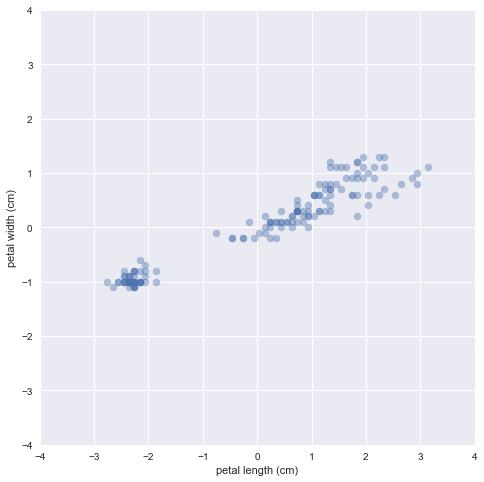

In [9]:
axes = plt.gca()
axes.set_ylim([-4, 4])
axes.set_xlim([-4, 4])
plt.gca().set_aspect('equal', adjustable='box')
p_x = demeaned_df['petal length (cm)']
p_y = demeaned_df['petal width (cm)']
plt.scatter(p_x, p_y, alpha = 0.4, s=50)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

### Fitting a line (hyperplane) to the input data

There would appear to be an approximately linear relationship between petal length and width, which is intuitively reasonable.

In the plot below, we additionally draw perpendicular lines (in green) from each data point back to the hyperplane.

In [10]:
def plot_line(angle_in_degrees):

    # original data
    plt.scatter(p_x, p_y, alpha = 0.4, s=50)
    
    # our current fitted line
    m = np.tan(np.pi * angle_in_degrees / 360)    
    x = np.linspace(-4, 4, 3)
    y = m * x
    plt.plot(x, y, 'r--')

    # perpendicular lines between the original data and the
    # current fitted line
    p_x_line = (p_x + m * p_y) / (m*m + 1)
    p_y_line = m * p_x_line
    for idx in range(len(p_x)):
        plt.plot([p_x[idx], p_x_line[idx]], [p_y[idx], p_y_line[idx]], color='g', alpha=0.1)
        
    # average sq distance from origin of perp line intercepts
    # i.e. the points where the green line touches the dashed red line
    var = np.mean(np.power(p_x_line, 2) + np.power(p_y_line, 2))
        
    plt.gca().set_aspect('equal', adjustable='box')
    axes = plt.gca()
    axes.set_ylim([-4, 4])
    axes.set_xlim([-4, 4])    
    
    plt.title('Variance {0:.4f}'.format(var))
    
    plt.xlabel('petal length (cm)')
    plt.ylabel('petal width (cm)')
    
    plt.show()

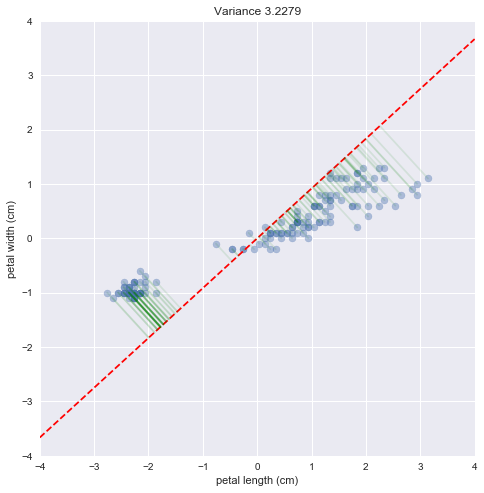

In [11]:
plot_line(85)  #static plot for arbitrarty slope angle

We introduced a quantity called **variance**:

```python
var = np.mean(np.power(p_x_line, 2) + np.power(p_y_line, 2))
```

If we define variance in the general sense for a discrete dataset as:

$$ Var(x) = \frac{1}{n} \sum_{n=1}^{n} (x_i−\mu)^2 $$

Noting that $\mu$ is zero for our de-meaned data set, and that - py Pythogoras - our $x_i$ values are the hypotenuse lengths of triangles with sides p_x_line and p_y_line, we have:

$$ Var(x) = \frac{1}{n} \sum_{n=1}^{n} (x_i-0)^2 $$

$$ Var(x) = \frac{1}{n} \sum_{n=1}^{n} (x_i)^2 $$

Noting that: $x^2$ = p_y_line$^2$ + p_x_line$^2$

Var(x) = $\frac{1}{n}$ (p_y_line$^2$ + p_x_line$^2$)

### Interactively changing the orientation of the hyperplane

We could try to fit a stright line through the data as a means of generalising the petal width / length relationship.  There are clearly inifinitely many solutions, but certain solutions have interesting properties.

> Try changing the slope of the line in the interactive plot below.  As you change the angle of the line:

> 1. Make a note of the plot title (variance)
> 2. Take a look at the green lines

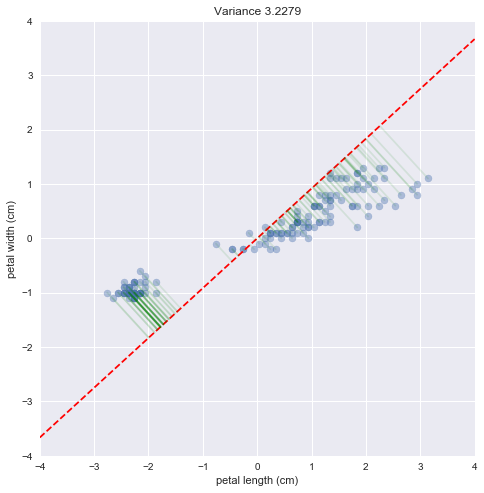

<function __main__.plot_line>

In [12]:
widgets.interact(plot_line,
                angle_in_degrees=widgets.FloatSlider(min=0, max=360, step=1, value=85))

As you vary the slope of the line, you should find that maximal variance is found at about 45 degrees.

Minimal variance is around 225 degrees - i.e. a line which is orthogonal to the line of maximum variance. 

The values were about 3.63 and 0.036 respectively.

Fast-forwarding a little, these are the 'explained variances' which a fitted PCA model returns.

> ```python
> petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].values
> pca = PCA().fit(petal_data)
> pca.explained_variance_
>
> array([ 3.63497866,  0.03597779])
> ``` 


### Programattically changing the orientation of the hyperplane

Let us programmatically vary the slope of the line and build a plot explained variance as a funtion of angle.


In [13]:
def get_variance(angle_in_degrees):
    
    x = p_x
    y = p_y

    # our current fitted line
    m = np.tan(np.pi * angle_in_degrees / 360)    
    y = m * x
    
    # perpendicular lines between the original data and the
    # current fitted line
    p_x_line = (p_x + m * p_y) / (m*m + 1)
    p_y_line = m * p_x_line
    
    # average sq distance from origin of perp line intercepts
    # i.e. the points where the green line touches the dashed red line
    var = np.mean(np.power(p_x_line, 2) + np.power(p_y_line, 2))
    
    return var

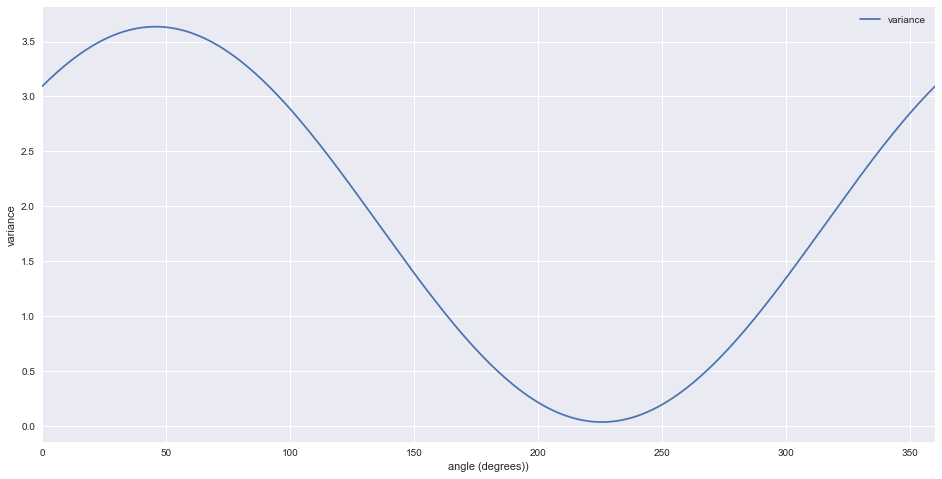

In [14]:
df = pd.DataFrame({'angle': range(361)})
df['variance'] = df.angle.apply(get_variance)
df = df.set_index('angle')
df.plot()
plt.xlabel('angle (degrees))')
plt.ylabel('variance')

We can use a solver to find the maxima and minima, which should correspond with our previous findings.

In [15]:
angle = fmin(lambda a: -1 * get_variance(a), 50)
var = get_variance(angle)
print('\nVariance: {0:.5f} obtained at angle: {1:.3f} degrees'.format(var, angle[0]))

Optimization terminated successfully.
         Current function value: -3.634979
         Iterations: 18
         Function evaluations: 36

Variance: 3.63498 obtained at angle: 45.693 degrees


In [16]:
angle = fmin(get_variance, 200) 
var = get_variance(angle)
print('\nVariance: {0:.5f} obtained at angle: {1:.3f} degrees'.format(var, angle[0]))

Optimization terminated successfully.
         Current function value: 0.035978
         Iterations: 20
         Function evaluations: 40

Variance: 0.03598 obtained at angle: 225.693 degrees


### Solving analytically

> In some ways, PCA provides us with an analytic mechanism for doing exactly what we did above.

The above procedure is perfectly valid and tractible for problems with 2 dimensions and small amounts of data.  But there are a number of analytic solutions to the problem which scale well and the above is intended just for building intuition.

What we've discovered so far is that (for our petal dataset) there exists exactly one axis which, when data points are projected onto it, exhibits maximal variance.  This is in fact our first Principal Component.

So we need an analytic approach to decompose the covariance of our data points and recover the principal axes.

The elements of a covariance matrix are given by:

$$ \sigma_{jk} = \frac{1}{n-1} \sum_{n=1}^{n} (x_{ij}−\overline{x}_j)(x_{ik}−\overline{x}_k) $$

In matrix notation:

$$ cov = \frac{1}{n-1} ((X−\overline{x})^T(X−\overline{x})) $$

As we've already de-meaned our data, our covariance matrix is given by:

In [17]:
petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].values

n = len(petal_data)
cov = 1 / (n - 1) * petal_data.T @ petal_data
cov

array([[ 3.11317942,  1.29638747],
       [ 1.29638747,  0.58241432]])

We can obtain this using numpy directly:

In [18]:
cov = np.cov(petal_data.T)
cov

array([[ 3.11317942,  1.29638747],
       [ 1.29638747,  0.58241432]])

**TODO** : add stuff about maximising variance in matrix form

The eigenvalues and corresponding vectors (organised in ascending eigenvalue order):

In [19]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)

In [20]:
eigenvalues

array([ 0.03621925,  3.65937449])

In [21]:
eigenvectors

array([[ 0.38826694, -0.92154695],
       [-0.92154695, -0.38826694]])

The eigenvalues look very close to the variance minimum and maximum we found earlier.  In fact, they're very closely related - the returned eigenvalues are just scaled differently.

Recall that we previously wrote down:

> ```python
> petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].values
> pca = PCA().fit(petal_data)
> pca.explained_variance_
>
> array([ 3.63497866,  0.03597779])
> ``` 

In [22]:
n  # number of data points
factor = (n - 1) /n
(factor * eigenvalues)[::-1]  # apply factor and flip the order

array([ 3.63497866,  0.03597779])

### Interpretation of eigenvectors

So what can we make of the eigenvectors?

The eigenvector corresponding to the largest eigenvalue is:

In [23]:
eigenvectors[:, -1]

array([-0.92154695, -0.38826694])

If we plot this over out original data, we can visualise this as the first principal component - i.e. the axis which explains maximal variance.

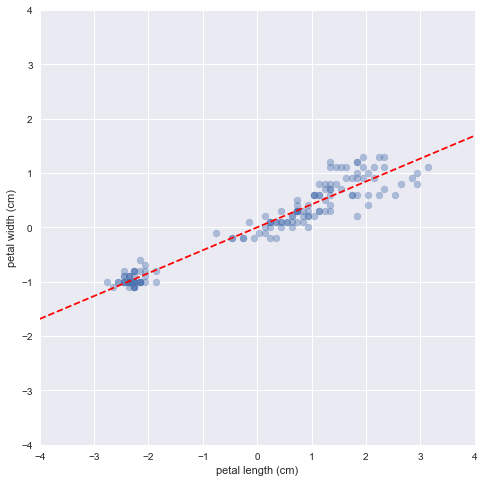

In [24]:
plt.scatter(p_x, p_y, alpha=0.4)

# slope
m = eigenvectors[:, -1][1]/eigenvectors[:, -1][0]

e_x = np.linspace(-4, 4, 3)
e_y = m * e_x

plt.plot(e_x, e_y, 'r--')

plt.gca().set_aspect('equal', adjustable='box')
axes = plt.gca()
axes.set_ylim([-4, 4])
axes.set_xlim([-4, 4])    

plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

We can check the angle implied by the first Principal Component against the value we solved for previously.

In [25]:
angle = np.arctan(eigenvectors[:, -1][1]/eigenvectors[:, -1][0])*360/np.pi
print('Angle implied by first eigenvector: {0:.3f} degrees'.format(angle))

Angle implied by first eigenvector: 45.693 degrees


We can trivially add the second eigenvector, which is orthogonal to the first and in fact the only other Principal Component that our two dimensional data has.

This gives us a new coordinate system whereby the axes are orthogonal to eath other and the variance of the data is maximal on the first axis.

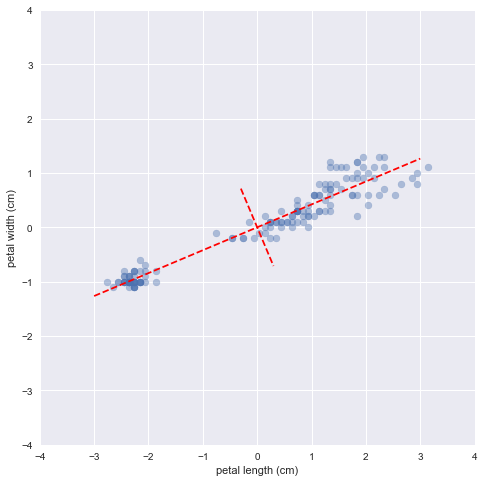

In [26]:
plt.scatter(p_x, p_y, alpha=0.4)

# slope
m1 = eigenvectors[:, -1][1]/eigenvectors[:, -1][0]
m2 = eigenvectors[:, 0][1]/eigenvectors[:, 0][0]

e_x1 = np.linspace(-3, 3, 3)
e_y1 = m1 * e_x1

e_x2 = np.linspace(-0.3, 0.3, 3)
e_y2 = m2 * e_x2

plt.plot(e_x1, e_y1, 'r--')
plt.plot(e_x2, e_y2, 'r--')

plt.gca().set_aspect('equal', adjustable='box')
axes = plt.gca()
axes.set_ylim([-4, 4])
axes.set_xlim([-4, 4])   

plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

We can use the eigenvectors to transform our original data into our new coordinate space:

In [27]:
transformed_data = petal_data @ eigenvectors
df_trans = pd.DataFrame(transformed_data, columns=['pc2', 'pc1'])
df_trans.head()

,pc2,pc1
0,0.004526,2.561371
1,0.004526,2.561371
2,-0.034301,2.653526
3,0.043353,2.469217
4,0.004526,2.561371


These new features are in fact just linear combinations of our original features.  

We can show this as follows.  Recall our original data (demeaned):

In [28]:
petal_df = demeaned_df[['petal length (cm)', 'petal width (cm)']].copy()
petal_df.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


The eigenvector corresponding to the largest eigenvalue was:

In [29]:
eigenvectors[:, -1]

array([-0.92154695, -0.38826694])

So instead of recording petal width and length, suppose we had recorded a quantity:
(-0.9215469 multiplied by length) + (-0.3882669 multiplied by width)

In [30]:
petal_df['new_qty'] = -0.92154695 * petal_df['petal length (cm)'] - 0.38826694 * petal_df['petal width (cm)']
petal_df.head()

,petal length (cm),petal width (cm),new_qty
0,-2.358667,-0.998667,2.561371
1,-2.358667,-0.998667,2.561371
2,-2.458667,-0.998667,2.653526
3,-2.258667,-0.998667,2.469217
4,-2.358667,-0.998667,2.561371


As follows, we can prove that **pc1** data exactly tallies with **new_qty**

In [31]:
np.allclose(df_trans.pc1, petal_df.new_qty)

True

The 'new_qty' is often called a 'score' and it would be normal to call the transformed values 'scores' - i.e. the values which each data point corresponds to in the new Principal Component space.

### Interpretation of eigenvalues

So what this means is that if we'd recorded the synthetic quantity (-0.9215469 multiplied by length) + (-0.3882669 multiplied by width), then we'd have **one** collection of data points which almost completely represents the information / variance of the original data which comprised **two** features (length and width).  These values would be the PC1 scores.

So what fraction of total variance would we retain?

The answer is given by the scaled eigenvalues.

In [32]:
scaled_eigenvalues = eigenvalues * (n - 1) / n
scaled_eigenvalues

array([ 0.03597779,  3.63497866])

In [33]:
scaled_eigenvalues / sum(scaled_eigenvalues)

array([ 0.00980066,  0.99019934])

This means that using PC1 alone explains 99% of the variance of our original data.

### Uncorrelated nature of principal components

One other fact to note is that the transformed data for PC1 and PC2 are uncorrelated (as a consequence of the orthoginal nature of the axes).  This should feel intuitively reasonable as moving along one axis does not impact the value on the other.

In [34]:
np.around(np.corrcoef(transformed_data.T), 3)

array([[ 1.,  0.],
       [ 0.,  1.]])

### Using sklearn

So let's revisit sklearn PCA and see how we'd use it to recover the above results.

In [35]:
petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].values
pca = PCA().fit(petal_data)

In [36]:
pca.explained_variance_

array([ 3.63497866,  0.03597779])

In [37]:
pca.explained_variance_ratio_

array([ 0.99019934,  0.00980066])

In [38]:
pca.components_

array([[ 0.92154695,  0.38826694],
       [-0.38826694,  0.92154695]])

Note that the transformed values have a flipped sign compared to the results we manually derived above. It doesn't really have any statistical significance and doesn't affect variance.  It would be trivial to add a conditioning step to determine a sign which matches sklearn. 

In [39]:
pd.DataFrame(pca.transform(petal_data), columns=['pc1', 'pc2']).head()

,pc1,pc2
0,-2.561371,-0.004526
1,-2.561371,-0.004526
2,-2.653526,0.034301
3,-2.469217,-0.043353
4,-2.561371,-0.004526


In [40]:
pca.get_covariance() * n / (n - 1)  # rescaled

array([[ 3.11317942,  1.29638747],
       [ 1.29638747,  0.58241432]])

The power of the sklearn model is that we can very simply reduce down to our desired number of dimesions.

In [41]:
petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].values
pca = PCA(n_components=1)
one_dimensional = pd.DataFrame(pca.fit_transform(petal_data), columns=['pc1'])
one_dimensional.head()

,pc1
0,-2.561371
1,-2.561371
2,-2.653526
3,-2.469217
4,-2.561371


The following plot shows the data points transformed into PC1 and then mapped back into the original coordinate system.  

Recalling the interactive chart above, the green dots repesent the projection of each blue data point onto the PC1 best fit line.  The difference between the green and blue dots gives an indication of the amount of information / variance which is lost by reducing to one dimension.

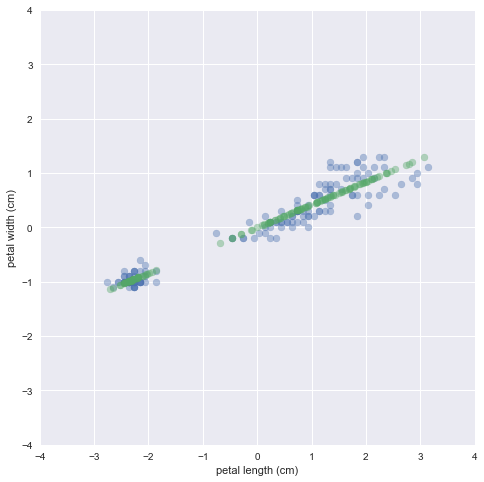

In [42]:
trans_data = pca.inverse_transform(one_dimensional.values)
x = trans_data[:, 0]
y = trans_data[:, 1]

plt.scatter(p_x, p_y, alpha=0.4)

plt.scatter(x, y, alpha=0.4)

plt.gca().set_aspect('equal', adjustable='box')
axes = plt.gca()
axes.set_ylim([-4, 4])
axes.set_xlim([-4, 4])    

plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

### Effect of including a feature with zero variance

PCA is a variance explanation technique.  What would happen if we added a feature which had zero variance?  Let's say we added a feature called 'animal, vegetable, mineral' which we one-hot encode into three columns: [animal, vegetable, mineral].

In [43]:
petal_df = demeaned_df[['petal length (cm)', 'petal width (cm)']].copy()
petal_df.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


In [44]:
petal_df['animal'] = 0
petal_df['vegetable'] = 1
petal_df['mineral'] = 0
petal_df.head()

,petal length (cm),petal width (cm),animal,vegetable,mineral
0,-2.358667,-0.998667,0,1,0
1,-2.358667,-0.998667,0,1,0
2,-2.458667,-0.998667,0,1,0
3,-2.258667,-0.998667,0,1,0
4,-2.358667,-0.998667,0,1,0


In [45]:
pca = PCA().fit(petal_df.values)

In [46]:
pca.explained_variance_ratio_

array([ 0.99019934,  0.00980066,  0.        ,  0.        ,  0.        ])

In [47]:
pca.explained_variance_

array([ 3.63497866,  0.03597779,  0.        ,  0.        ,  0.        ])

In [48]:
pca.components_

array([[ 0.92154695,  0.38826694,  0.        ,  0.        ,  0.        ],
       [-0.38826694,  0.92154695,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [49]:
pd.DataFrame(pca.transform(petal_df.values), columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5']).head()

,pc1,pc2,pc3,pc4,pc5
0,-2.561371,-0.004526,0.0,0.0,0.0
1,-2.561371,-0.004526,0.0,0.0,0.0
2,-2.653526,0.034301,0.0,0.0,0.0
3,-2.469217,-0.043353,0.0,0.0,0.0
4,-2.561371,-0.004526,0.0,0.0,0.0


As you might expect, the features which have no variance are not useful in explaining the variance of the dataset, so PC1 and PC2 are unchanged.

### Effect of including a features with different scales

What would happen if the dimensions we'd recorded had different scales?  So let's say we recorded petal width in meters and petal length in milimeters.

In [50]:
petal_data = demeaned_df[['petal length (cm)', 'petal width (cm)']].copy()

In [51]:
petal_data.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


In [52]:
petal_data['petal length (mm)'] = petal_data['petal length (cm)'] * 10
petal_data['petal width (m)'] = petal_data['petal width (cm)'] /100
del petal_data['petal length (cm)']
del petal_data['petal width (cm)']

In [53]:
petal_data.head()

,petal length (mm),petal width (m)
0,-23.586667,-0.009987
1,-23.586667,-0.009987
2,-24.586667,-0.009987
3,-22.586667,-0.009987
4,-23.586667,-0.009987


In [54]:
pca = PCA().fit(petal_data)

In [55]:
pca.explained_variance_

array([  3.09242543e+02,   4.22899390e-06])

In [56]:
pca.explained_variance_ratio_

array([  9.99999986e-01,   1.36753301e-08])

So, perhaps unsurprisingly as PCA 'works' by explaining the variance in the data, the enormously different scales of the inputs means that one feature dominates the other.  This is perhaps something to bear in mind when working with cross-sectional data where features use very different scales.

### Data pre-conditioning by z-scoring

So what can we do about it?  One option is to z-score.

In [57]:
def zscore(series):
    return (series - series.mean()) / series.std()

petal_data_std = petal_data.apply(zscore)
petal_data_std.columns = ['petal length', 'petal width']
petal_data_std.head()

,petal length,petal width
0,-1.336794,-1.308593
1,-1.336794,-1.308593
2,-1.393470,-1.308593
3,-1.280118,-1.308593
4,-1.336794,-1.308593


In [58]:
pca = PCA().fit(petal_data_std)

In [59]:
pca.explained_variance_

array([ 1.94967205,  0.03699462])

In [60]:
pca.explained_variance_ratio_

array([ 0.98137855,  0.01862145])

There are many ways of normalising data; z-scoring is just one.  So should features *always* be scaled before fitting a PCA model?  That's a matter of some debate; a valid counter argument is that it can artificially 'inflate' the contribution of an otherwise relatively unimportant feature.  In any event, it makes sense to be explicit about what preconditioning (if any) you've decided to use and why.

A corrollary of z-scoring is that it makes the covariance matrix and correlation matrix equal.

In [61]:
np.cov(petal_data_std.T)

array([[ 1.       ,  0.9627571],
       [ 0.9627571,  1.       ]])

In [62]:
np.corrcoef(petal_data_std.T)

array([[ 1.       ,  0.9627571],
       [ 0.9627571,  1.       ]])

We've hithero chosen to decompose the data's covariance matrix but it may be valid to instead decompose the correlation matrix (e.g. where data scaling is a significant factor).  In the event that input features are preconditioned using z-scoring then it makes no difference.

### Effect of including a feature which is perfectly correlated with some other feature

What happens if we introduce a feature which is perfectly correlated with some other feature?

In [63]:
petal_df = petal_df[['petal length (cm)', 'petal width (cm)']].copy()
petal_df.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


In [64]:
petal_df['length_times_factor'] = petal_df['petal length (cm)'] * 0.8
petal_df.head()

,petal length (cm),petal width (cm),length_times_factor
0,-2.358667,-0.998667,-1.886933
1,-2.358667,-0.998667,-1.886933
2,-2.458667,-0.998667,-1.966933
3,-2.258667,-0.998667,-1.806933
4,-2.358667,-0.998667,-1.886933


In [65]:
petal_df.corr()

,petal length (cm),petal width (cm),length_times_factor
petal length (cm),1.000000,0.962757,1.000000
petal width (cm),0.962757,1.000000,0.962757
length_times_factor,1.000000,0.962757,1.000000


In [66]:
pca = PCA().fit(petal_df.values)

In [67]:
pca.explained_variance_ratio_

array([  9.93235835e-01,   6.76416520e-03,   7.80531918e-33])

In [68]:
pca.explained_variance_

array([  5.61189011e+00,   3.82182664e-02,   4.41008993e-32])

In [69]:
pca.components_

array([[  7.42055371e-01,   3.11352335e-01,   5.93644296e-01],
       [ -2.43125327e-01,   9.50294546e-01,  -1.94500262e-01],
       [  6.24695048e-01,  -1.11022302e-16,  -7.80868809e-01]])

In [70]:
df = pd.DataFrame(pca.transform(petal_df.values), columns=['pc1', 'pc2', 'pc3']).head()
df

,pc1,pc2,pc3
0,-3.181366,-0.008567,0.0
1,-3.181366,-0.008567,0.0
2,-3.303063,0.031306,0.0
3,-3.059669,-0.048439,0.0
4,-3.181366,-0.008567,0.0


So what's happening here is that we end up with a third principal component which is not useful at all in explaining variance.  

Indeed, the linear combination of features is zero (i.e. all the scores are zero).  Here's ehat happens when we apply the factors to the first data point.

In [71]:
pca.components_[-1]

array([  6.24695048e-01,  -1.11022302e-16,  -7.80868809e-01])

In [72]:
sum(pca.components_[-1] * petal_df.values[0])

-2.2204460492503131e-16

And note that if we sum pc3, it's approximately zero.

In [73]:
df.pc3.sum()

0.0